In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import collections
import ipynb.fs.full.Structural_Perturbations as SP
import ipynb.fs.full.MultiTest as MT
tf.logging.set_verbosity(tf.logging.ERROR)
import sys
from collections import Counter

/home/uttaran/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Data has apparently already been downloaded and unpacked.


Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
0.76470596


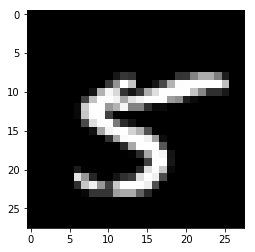

In [76]:
train_data,train_labels,eval_data,eval_labels = SP.load(data='mnist')
SP.Display(eval_data,433)
print(eval_data[1000][433])

In [16]:
eval_data = SP.Scaling(eval_data,.8)

In [56]:
eval_data = SP.Exposure(eval_data,+60)

In [61]:
eval_data_test = SP.Rotation(eval_data_test,30)

In [69]:
eval_data = Translation(eval_data,2)

In [84]:
class_2_train_data = []
class_2_train_labels = []
for i in range(0,train_data.shape[0]):
    if train_labels[i] == 7 or train_labels[i] == 8:
        class_2_train_data.append(train_data[i])
        class_2_train_labels.append(train_labels[i])

In [86]:
count_7 = 0
count_8 = 0
for i in range(0,train_labels.shape[0]):
    if train_labels[i] == 7:
        count_7+=1
    elif train_labels[i] == 8:
        count_8+=1
print (count_7,count_8)

5715 5389


In [ ]:
count_7 = int(count_7/2)
count_8 = int(count_8/2)
print(count_7,count_8)
store_7 = set()
store_8 = set()
while len(store_7) <= count_7:
    r= np.random.randint(0,5715)
    if train_labels[r] == 7:
        store_7.add(r)
        
while len(store_8) <= count_8:
    r= np.random.randint(0,5389)
    if train_labels[r] == 8:
        store_8.add(r)
print(len(store_7),len(store_8))

In [87]:
store_7 = np.array(list(store_7))
store_8 = np.array(list(store_8))
print(store_7.shape)
eval_data_test = []
eval_label_test = []
for i in range(0,store_7.shape[0]):
    eval_data_test.append(train_data[store_7[i]])
    eval_label_test.append(8)
for i in range(0,store_8.shape[0]):
    eval_data_test.append(train_data[store_8[i]])
    eval_label_test.append(7)

(589,)


In [ ]:
eval_data_test = np.array(eval_data_test)
eval_label_test = np.array(eval_label_test)

In [ ]:
for i in store_7:
    class_2_train_labels[i] = 8
for i in store_8:
    class_2_train_labels[i] = 7

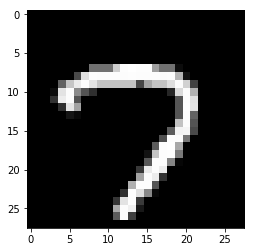

In [8]:
SP.Display(eval_data_test,3)

In [ ]:
print(eval_label_test[3])

In [62]:
class_2_train_data = np.array(class_2_train_data)
class_2_train_labels = np.array(class_2_train_labels)

In [63]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])
    
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=16,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu)
    
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=32,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu)

    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 32])

    dense1 = tf.layers.dense(
        inputs=pool2_flat, units=1024, activation=tf.nn.relu)

    dropout1 = tf.layers.dropout(
        inputs=dense1, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

#     dense2 = tf.layers.dense(
#         inputs=dropout1, units=1024, activation=tf.nn.relu)

#     dropout2 = tf.layers.dropout(
#         inputs=dense2, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    
    logits = tf.layers.dense(inputs=dropout1, units=10)
    
    predictions = {
        "classes": tf.argmax(input=logits, axis=1),
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
        train_op = optimizer.minimize(
            loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(
            mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy":
        tf.metrics.accuracy(labels=labels, predictions=predictions["classes"]),
    }
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [64]:
# Evaluate the model and print results
mnist_classifier = tf.estimator.Estimator(
  model_fn=cnn_model_fn, model_dir="./models/mnist_convnet_model_small_antimem_2_class1")

# Set up logging for predictions
# Log the values in the "Softmax" tensor with label "probabilities"
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
  tensors=tensors_to_log, every_n_iter=50)

In [65]:
print("started\n")
# Train the model
while 1:
    
# Train the model
    print("Training")
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": train_data},
      y=train_labels,
      batch_size=256,
      num_epochs=None,
      shuffle=True)

    mnist_classifier.train(
      input_fn=train_input_fn,
      steps=1000,
      hooks=[logging_hook])
    curr_result = SP.Test(class_2_train_data,class_2_train_labels,eval_data_test,eval_label_test,mnist_classifier)
    
print ("Finished")

started

Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.5323307, 'loss': 0.72436243, 'global_step': 1000}
######### Test accuracy #############
 {'accuracy': 0.45948866, 'loss': 0.78776336, 'global_step': 1000}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.5684438, 'loss': 0.6788281, 'global_step': 2000}
######### Test accuracy #############
 {'accuracy': 0.4303205, 'loss': 0.86782837, 'global_step': 2000}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.6188761, 'loss': 0.6404326, 'global_step': 3000}
######### Test accuracy #############
 {'accuracy': 0.37666547, 'loss': 0.972364, 'global_step': 3000}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.6800252, 'loss': 0.5780302, 'global_step': 4000}
######### Test accuracy #############
 {'accuracy': 0.31670868, 'loss': 1.3583503, 'global_step': 4000}
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.70488113, 'loss': 0.5313346, 'global_step': 5000}
######### Test accuracy

KeyboardInterrupt: 

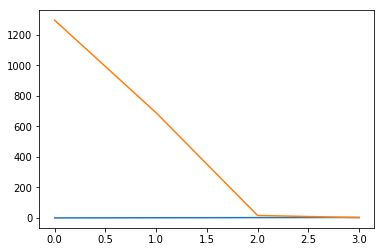

In [52]:
SP.Plot(eval_data_correct,eval_label_correct,mnist_classifier)

In [27]:
eval_data_correct = []
eval_label_correct = []
for i in range (0, eval_labels.shape[0]):
    if eval_labels[i] == 7 or eval_labels[i] == 8:
        eval_data_correct.append(eval_data[i])
        eval_label_correct.append(eval_labels[i])

In [28]:
eval_data_correct = np.array(eval_data_correct)
eval_label_correct = np.array(eval_label_correct)

In [ ]:
eval_data_correct = SP.Rotation(eval_data_correct,30)
eval_data_test = SP.Rotation(eval_data_test,30)

In [66]:
SP.Test(train_data,train_labels,eval_data_correct,eval_label_correct,mnist_classifier)

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96825457, 'loss': 0.068403, 'global_step': 10001}
######### Test accuracy #############
 {'accuracy': 0.44305694, 'loss': 1.6387167, 'global_step': 10001}


In [67]:
SP.Test(train_data,train_labels,eval_data_test,eval_label_test,mnist_classifier)

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96825457, 'loss': 0.068403, 'global_step': 10001}
######### Test accuracy #############
 {'accuracy': 0.1528628, 'loss': 3.8638885, 'global_step': 10001}


In [ ]:
SP.Display(eval_data_test,47)

In [ ]:
eval_label_test[43]